In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from datetime import datetime, timedelta
from datetime import datetime
import pandas as pd

In [2]:
conf = SparkConf() \
    .setAppName("telegram-prediction") \
    .setMaster("local[*]") \
    .set('spark.jars', 'spark-cassandra-connector-assembly_2.12-3.0.1.jar')

In [3]:
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [4]:
df = sqlContext.read.format("org.apache.spark.sql.cassandra") \
    .option("spark.cassandra.auth.username", "cassandra") \
    .option("spark.cassandra.auth.password", "cassandra") \
    .options(table="channels", keyspace="telegram_data").load()

In [5]:
train_data = df.where(F.col('sender_username') == 'khabar_Forl')#uttweet
train_data = train_data.toPandas()
train_data['send_date'] = pd.to_datetime(train_data['send_date'])
train_data['send_date'] = [dt.strftime('%Y-%m-%d %H:%M:00') for dt in train_data['send_date']]
train_data["send_date"]=train_data["send_date"]
train_data["y"]=1
train_data=train_data[["send_date","y"]]
train_data.columns = ['ds', 'y']


In [6]:
train_data

,ds,y
0,2021-07-13 16:50:00,1
1,2021-07-13 16:51:00,1
2,2021-07-13 16:51:00,1
3,2021-07-13 16:57:00,1
4,2021-07-13 17:10:00,1
...,...,...
780,2021-07-19 20:10:00,1
781,2021-07-19 20:11:00,1
782,2021-07-19 20:29:00,1
783,2021-07-19 20:41:00,1


In [7]:
def range_datetime(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

In [8]:
dts = [dt.strftime('%Y-%m-%d %H:%M:00') for dt in
       range_datetime(datetime(2021, 7, 13, 0 , 0), datetime(2021, 7, 18, 23 ,59), timedelta(minutes=1))]

In [9]:
y = [0 for i in range(len(dts))]
for i in range(len(dts)):
    if dts[i] in list(train_data['ds']):
        y[i] = (sum((train_data[train_data['ds'] == dts[i]]['y']).values))

In [10]:
midd_data = {'ds': dts, 'y': y}
df_train = pd.DataFrame(midd_data)
df_train

,ds,y
0,2021-07-13 00:00:00,0
1,2021-07-13 00:01:00,0
2,2021-07-13 00:02:00,0
3,2021-07-13 00:03:00,0
4,2021-07-13 00:04:00,0
...,...,...
8634,2021-07-18 23:54:00,1
8635,2021-07-18 23:55:00,0
8636,2021-07-18 23:56:00,0
8637,2021-07-18 23:57:00,0


In [11]:
train_data.loc[train_data.y ==1]

,ds,y
0,2021-07-13 16:50:00,1
1,2021-07-13 16:51:00,1
2,2021-07-13 16:51:00,1
3,2021-07-13 16:57:00,1
4,2021-07-13 17:10:00,1
...,...,...
780,2021-07-19 20:10:00,1
781,2021-07-19 20:11:00,1
782,2021-07-19 20:29:00,1
783,2021-07-19 20:41:00,1


In [12]:
df1 = df_train[df_train['y'] == 0].sample(len(df_train[df_train['y'] == 0]) - len(df_train[df_train['y'] == 1]))
df_train = df_train[~df_train.index.isin(df1.index)]

In [13]:
df_train.head(5)

,ds,y
4,2021-07-13 00:04:00,0
86,2021-07-13 01:26:00,0
159,2021-07-13 02:39:00,0
176,2021-07-13 02:56:00,0
220,2021-07-13 03:40:00,0


In [14]:
from fbprophet import Prophet
m = Prophet().fit(df_train)

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [22]:
future = m.make_future_dataframe(periods=24*60, freq='min', include_history=True)
fcst = m.predict(future)

In [23]:
fcst[-540:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1577,2021-07-19 14:55:00,0.847675,-0.051112,2.451903,0.847607,0.847753,0.384588,0.384588,0.384588,0.384588,0.384588,0.384588,0.0,0.0,0.0,1.232264
1578,2021-07-19 14:56:00,0.847697,0.018656,2.637709,0.847628,0.847775,0.385948,0.385948,0.385948,0.385948,0.385948,0.385948,0.0,0.0,0.0,1.233645
1579,2021-07-19 14:57:00,0.847718,0.030336,2.593438,0.847649,0.847796,0.387310,0.387310,0.387310,0.387310,0.387310,0.387310,0.0,0.0,0.0,1.235028
1580,2021-07-19 14:58:00,0.847739,-0.048320,2.482445,0.847670,0.847817,0.388674,0.388674,0.388674,0.388674,0.388674,0.388674,0.0,0.0,0.0,1.236413
1581,2021-07-19 14:59:00,0.847760,-0.134777,2.424163,0.847691,0.847839,0.390039,0.390039,0.390039,0.390039,0.390039,0.390039,0.0,0.0,0.0,1.237799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112,2021-07-19 23:50:00,0.859008,-0.598066,1.947327,0.858866,0.859165,-0.185544,-0.185544,-0.185544,-0.185544,-0.185544,-0.185544,0.0,0.0,0.0,0.673465
2113,2021-07-19 23:51:00,0.859030,-0.677569,1.937428,0.858888,0.859186,-0.191646,-0.191646,-0.191646,-0.191646,-0.191646,-0.191646,0.0,0.0,0.0,0.667384
2114,2021-07-19 23:52:00,0.859051,-0.639377,1.853245,0.858909,0.859208,-0.197737,-0.197737,-0.197737,-0.197737,-0.197737,-0.197737,0.0,0.0,0.0,0.661314
2115,2021-07-19 23:53:00,0.859072,-0.603876,2.022694,0.858930,0.859229,-0.203816,-0.203816,-0.203816,-0.203816,-0.203816,-0.203816,0.0,0.0,0.0,0.655256


In [36]:
rslt_df = fcst.loc[(fcst['yhat'] > 1) & (fcst['ds']>datetime(2021,7,19,0,0,0))]

In [45]:
rslt_df.iloc[0].ds

Timestamp('2021-07-19 09:12:00')

In [44]:
((rslt_df.iloc[0].ds-datetime(2021,7,19,0,0,0)).total_seconds())/60

552.0

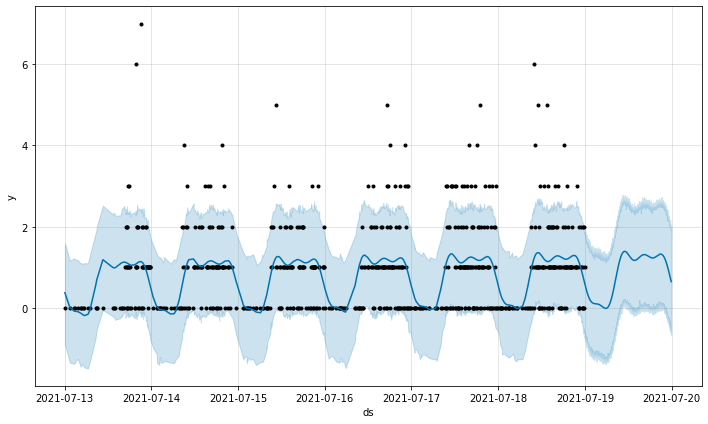

In [26]:
fig = m.plot(fcst)